In [1]:
# !pip install transformers
# !pip install datasets
# !pip install seaborn
# !pip install matplotlib

     |████████████████████████████████| 4.7 MB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 101 kB 7.1 MB/s ta 0:00:011
     |████████████████████████████████| 6.6 MB 8.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [306]:
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor
import torch
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import PIL
import torch
import torchvision.transforms as T
import numpy as np

# Datasets
   - cat
   - plane

In [146]:
# cat
dataset = load_dataset("huggingface/cats-image")
image_cat = dataset["test"]["image"][0]

No config specified, defaulting to: cats-image/image
Reusing dataset cats-image (/root/.cache/huggingface/datasets/huggingface___cats-image/image/1.9.0/68fbc793fb10cd165e490867f5d61fa366086ea40c73e549a020103dcb4f597e)


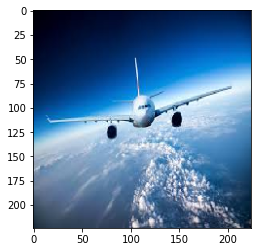

In [151]:
image = PIL.Image.open('./dataset/plane.png')
plt.imshow(image)
plt.show()

In [153]:
image.size

(224, 224)

# Load ViT Model

In [17]:
# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
model.config

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.21.1"
}

In [388]:
# input transform
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = feature_extractor(image, return_tensors="pt")
# load model
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# inference by vit
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True, interpolate_pos_encoding=True, return_dict=True)

In [155]:
inputs['pixel_values'].size()

torch.Size([1, 3, 224, 224])

In [389]:
# last layer hidden_state outputs of cls token

len(outputs.pooler_output), outputs.pooler_output.size() 

(1, torch.Size([1, 768]))

In [390]:
# hidden_state outpus of every layers

len(outputs.hidden_states), outputs.hidden_states[0].size()

(13, torch.Size([1, 197, 768]))

In [391]:
# attention map of every layers

len(outputs.attentions[0][0]), outputs.attentions[0][0].size()

(12, torch.Size([12, 197, 197]))

In [392]:
outputs.hidden_states[0] #hidden state: 0: before 1th transformer block, 1~12: specific layerth transformer block output

tensor([[[-3.3752e-03,  1.3522e-02, -4.8854e-01,  ..., -5.6801e-03,
          -7.6900e-04, -7.5266e-01],
         [ 1.2075e-01, -4.9652e-02,  1.1028e-01,  ...,  5.1020e-02,
          -1.0225e-02, -1.4759e+00],
         [-1.9232e-04,  3.7784e-02, -9.0700e-02,  ...,  1.0614e-01,
           1.0756e-01, -1.4363e+00],
         ...,
         [-7.9713e-01,  2.4594e-01, -3.2904e-01,  ...,  8.4802e-01,
           4.5545e-01, -1.1403e+00],
         [-2.7130e-01, -1.3891e+00, -1.3270e-01,  ...,  8.3945e-01,
          -1.7128e+00, -1.0548e+00],
         [-5.5923e-01,  2.7147e-01,  1.5355e-02,  ..., -2.4223e-01,
          -6.9559e-01, -1.3241e+00]]])

In [393]:
#attention: 모두 양수의 값, 즉 softmax(Q*K.T/(dk)^1/2)

outputs.attentions[0][0][0][outputs.attentions[0][0][0] < 0] 

tensor([])

# Attention Maps by layer
 - output.attentions
     - 12 layers
     - Size: (197 X 197)

In [163]:
len(outputs.attentions)

12

In [164]:
outputs.attentions[0].size()

torch.Size([1, 12, 197, 197])

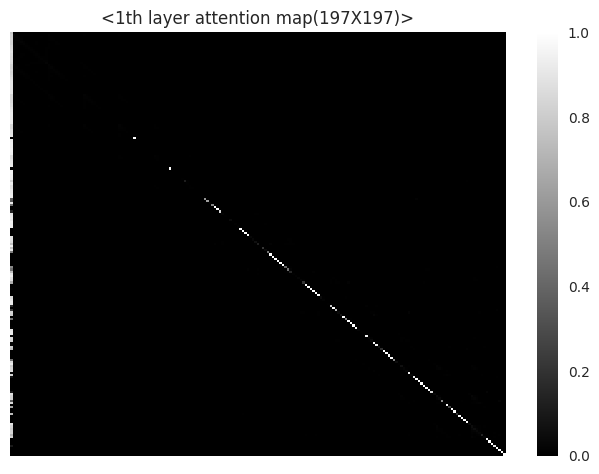

In [441]:
fig = plt.figure()
plt.style.use(['seaborn'])
cmap = cm.get_cmap('gray')
sns.heatmap(outputs.attentions[0][0][0], cmap=cmap)
plt.title(f"<1th layer attention map(197X197)>")
plt.axis('off')
plt.show()

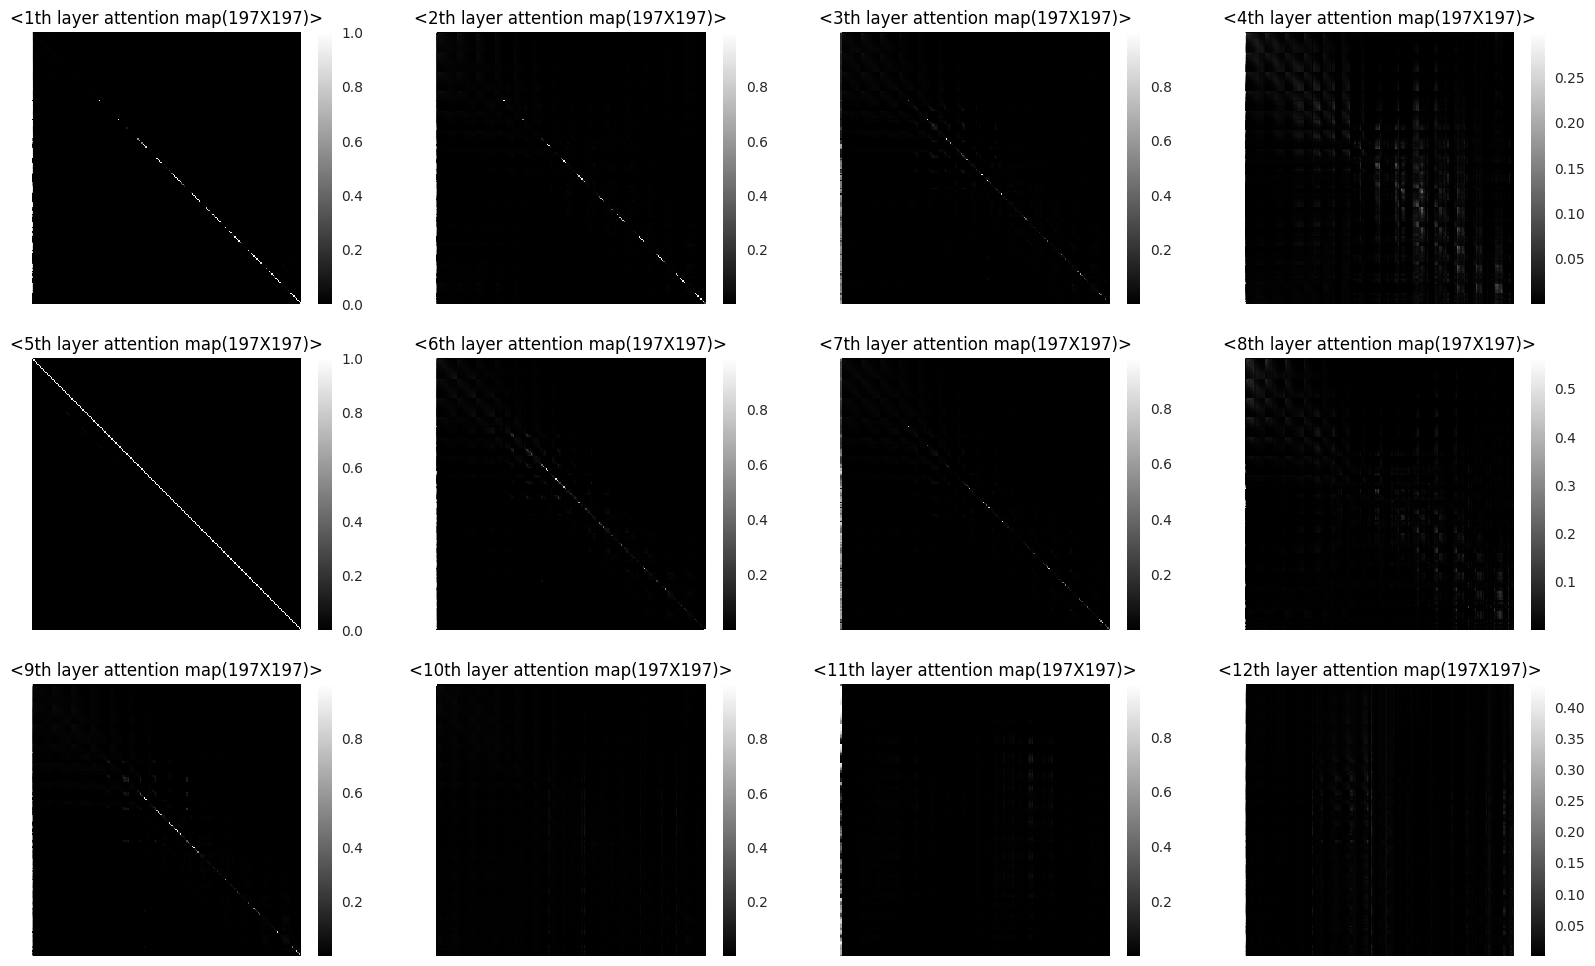

In [438]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))
plt.style.use(['seaborn'])
cmap = cm.get_cmap('gray')

for idx in range(len(outputs.attentions)):

        ax = axes.ravel().tolist()[idx]
        sns.heatmap(outputs.attentions[0][0][idx], cmap=cmap, ax=ax)
#         sns.heatmap(outputs.hidden_states[idx][0], ax=ax)
        ax.set_title(f"<{idx+1}th layer attention map(197X197)>")
        ax.set_axis_off()

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)      

plt.show()

# Classification Token Attention Map by layer
   - outputs.attention
       - first row, without myself(cls_token)
       - 12 layers
       - Size: (1 X 196)

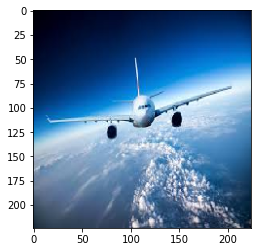

In [151]:
image = PIL.Image.open('./dataset/plane.png')
plt.imshow(image)
plt.show()

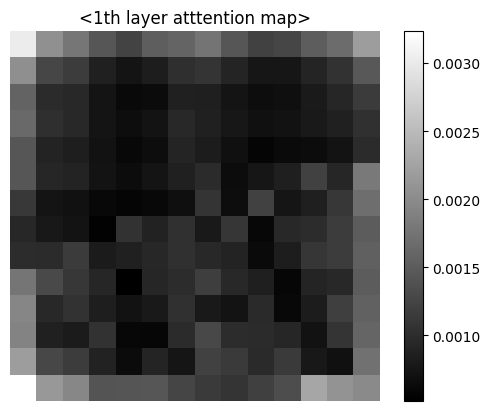

In [442]:
plt.style.use(['default'])
cmap = cm.get_cmap('gray')

cls_1 = outputs.attentions[0][0][0][0,1:].view(14,14)
plt.imshow(cls_1, cmap=cmap)
plt.title(f"<1th layer atttention map>")
plt.axis('off')
plt.colorbar()
plt.show()

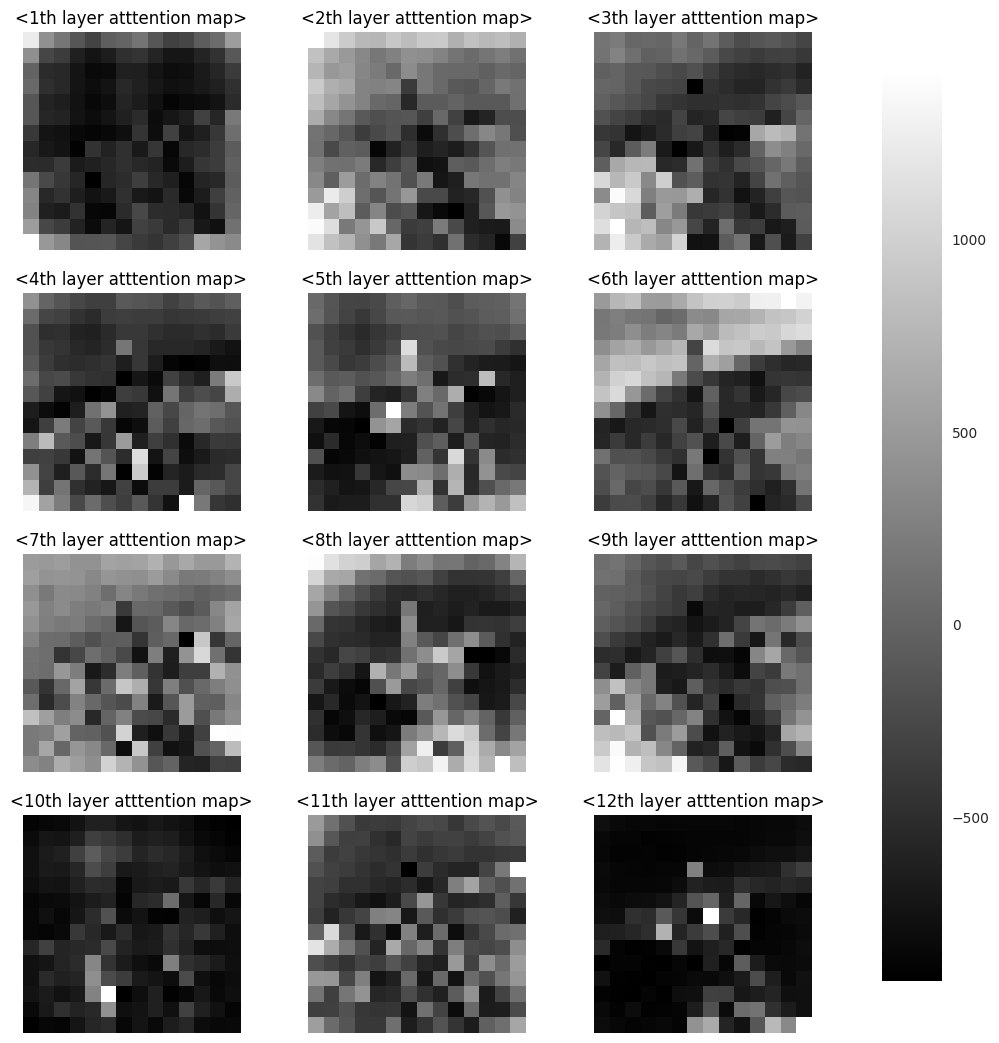

In [436]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 13))
plt.style.use(['seaborn'])
cmap = cm.get_cmap('gray')

for row in range(4):
    for col in range(3):
        idx = row * 3 + col
        
        if idx < len(outputs.attentions):
            ax = axes[row][col]
            ax.imshow(outputs.attentions[0][0][idx][0,1:].view(14,14), cmap=cmap)
            ax.set_title(f"<{idx+1}th layer atttention map>")
            ax.set_axis_off()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)      

plt.show()

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


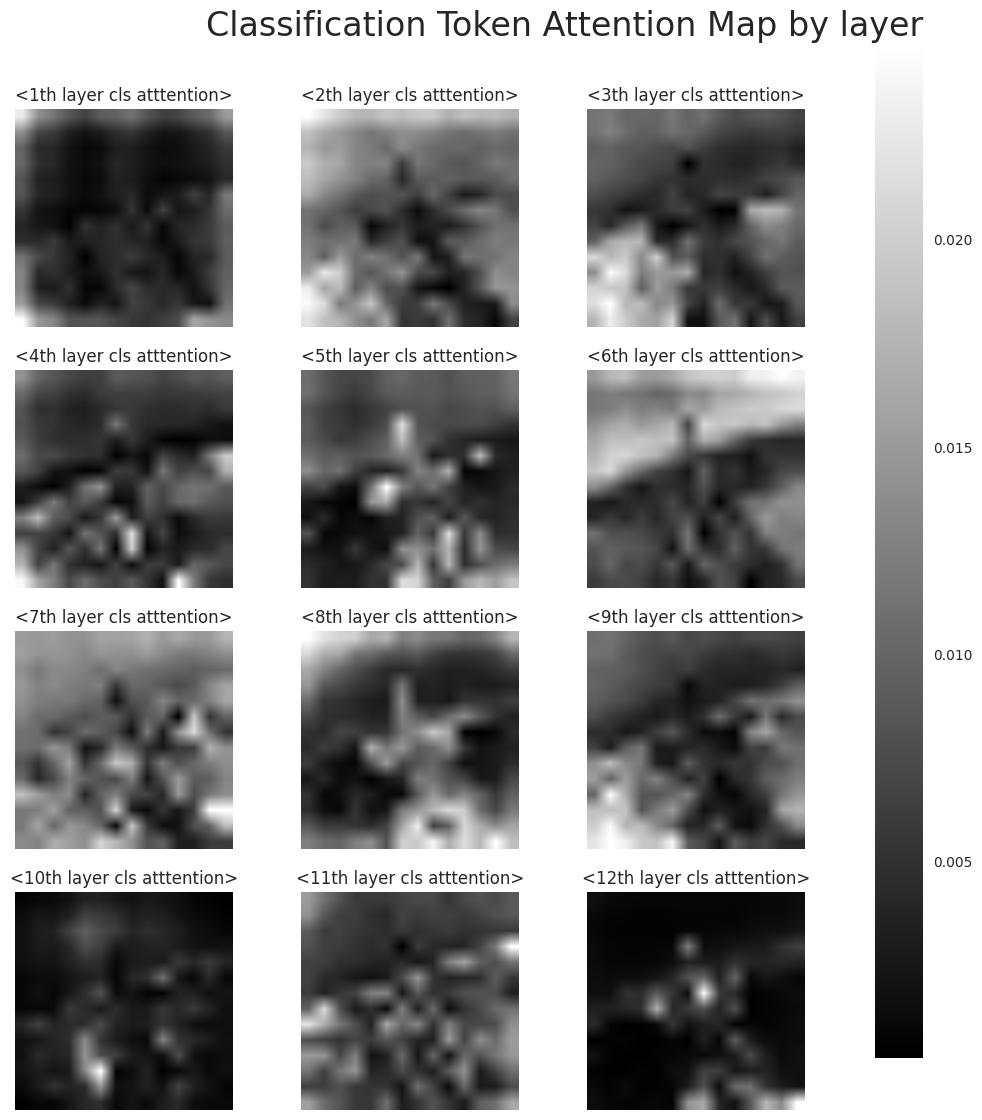

In [496]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 13))
plt.style.use(['seaborn'])
cmap = cm.get_cmap('gray') # import matplotlib.cm as cm

for idx, ax in enumerate(axes.flat):
    cls_i = outputs.attentions[0][0][idx][0,1:].view(14,14)
    #interpolation - "trilinear"
    cls_i_224 = torch.nn.functional.interpolate(cls_i.unsqueeze(0).unsqueeze(0).unsqueeze(0), size=(1,224,224), mode='trilinear')
    cls_i_tri = cls_i_224.squeeze()
    im = ax.imshow(cls_i_tri, cmap=cmap)
    ax.set_title(f"<{idx+1}th layer cls atttention>")
    ax.set_axis_off()

fig.subplots_adjust(right=0.8) # fig - palette adjust
cbar_ax = fig.add_axes([0.85, 0.15, 0.04, 0.78]) #cbar [x, y, width, height]
fig.colorbar(im, cax=cbar_ax)          
# fig.colorbar(im, ax=axes.ravel().tolist())


plt.title("Classification Token Attention Map by layer", fontdict={'fontsize': 24}, loc='right')
plt.show()

In [499]:
for idx in range(len(outputs.attentions)):
    print(outputs.attentions[0][0][idx][0,1:])

tensor([0.0030, 0.0020, 0.0018, 0.0014, 0.0012, 0.0015, 0.0016, 0.0018, 0.0014,
        0.0012, 0.0013, 0.0015, 0.0017, 0.0022, 0.0020, 0.0013, 0.0012, 0.0009,
        0.0007, 0.0008, 0.0010, 0.0011, 0.0009, 0.0008, 0.0008, 0.0009, 0.0010,
        0.0015, 0.0016, 0.0010, 0.0009, 0.0007, 0.0006, 0.0006, 0.0009, 0.0009,
        0.0007, 0.0007, 0.0007, 0.0008, 0.0009, 0.0011, 0.0016, 0.0010, 0.0010,
        0.0007, 0.0007, 0.0007, 0.0010, 0.0009, 0.0008, 0.0007, 0.0007, 0.0008,
        0.0009, 0.0010, 0.0014, 0.0009, 0.0008, 0.0007, 0.0006, 0.0007, 0.0009,
        0.0008, 0.0007, 0.0006, 0.0006, 0.0007, 0.0007, 0.0010, 0.0014, 0.0009,
        0.0009, 0.0007, 0.0006, 0.0007, 0.0009, 0.0010, 0.0007, 0.0008, 0.0008,
        0.0012, 0.0009, 0.0018, 0.0011, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006,
        0.0007, 0.0011, 0.0007, 0.0012, 0.0007, 0.0008, 0.0011, 0.0017, 0.0009,
        0.0008, 0.0007, 0.0005, 0.0011, 0.0009, 0.0010, 0.0008, 0.0011, 0.0006,
        0.0009, 0.0010, 0.0012, 0.0015, 

# Hidden States by layers
   - output.hidden_states
       - 13 (12 layers out + input into 1 layer)
       - Size: (197 X 768)

In [167]:
len(outputs.hidden_states)

13

In [168]:
outputs.hidden_states[0].size()

torch.Size([1, 197, 768])

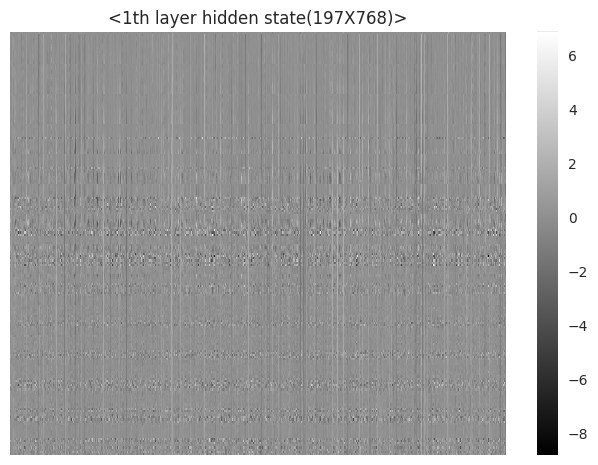

In [447]:
fig = plt.figure()
plt.style.use(['seaborn'])
cmap = cm.get_cmap('gray')
sns.heatmap(outputs.hidden_states[0][0], cmap=cmap)
plt.title(f"<1th layer hidden state(197X768)>")
plt.axis('off')
plt.show()

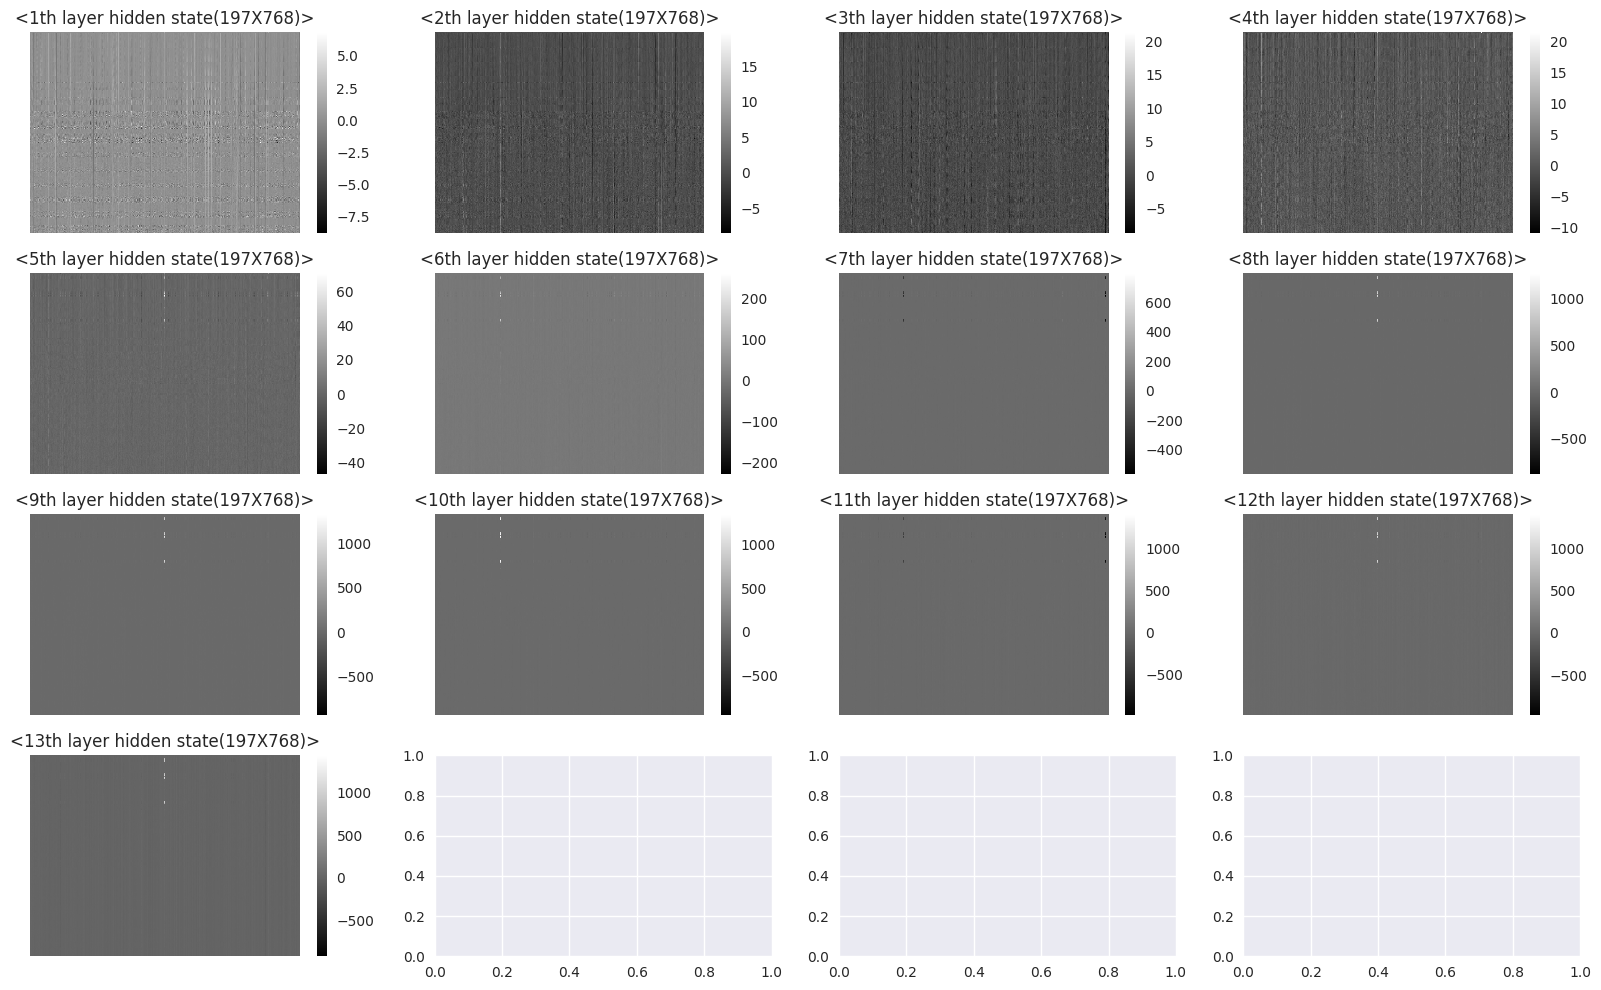

In [501]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 12))
plt.style.use(['seaborn'])
cmap = cm.get_cmap('gray')

for idx in range(len(outputs.hidden_states)):

        ax = axes.ravel().tolist()[idx]
        sns.heatmap(outputs.hidden_states[idx][0], cmap=cmap, ax= ax)
#         sns.heatmap(outputs.hidden_states[idx][0], ax=ax)
        ax.set_title(f"<{idx+1}th layer hidden state(197X768)>")
        ax.set_axis_off()

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)      

plt.show()

# Hidden States of last layer by channel
   - outputs.last_hidden_states
       - 768 channels -> What is meaning of channels in transformer?
       - Size: (197 X 768)

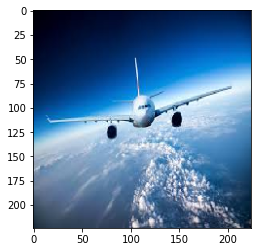

In [151]:
image = PIL.Image.open('./dataset/plane.png')
plt.imshow(image)
plt.show()

In [457]:
outputs.last_hidden_state.size() # 1th layer output

torch.Size([1, 197, 768])

In [459]:
hs_last = outputs.last_hidden_state.squeeze(0)
hs_last.size()

torch.Size([197, 768])

In [460]:
# cls token

hs_last_cls = hs_last[0,:]
hs_last_cls.size()

torch.Size([768])

In [461]:
#without cls token

hs_last_wo_cls = hs_last[1:,:]
hs_last_wo_cls.size()

torch.Size([196, 768])

In [464]:
# 1th channel visualization

hs_last_wo_cls[:,0].size()

hs_last_wo_cls[:,0].view(14,14)

torch.Size([196])

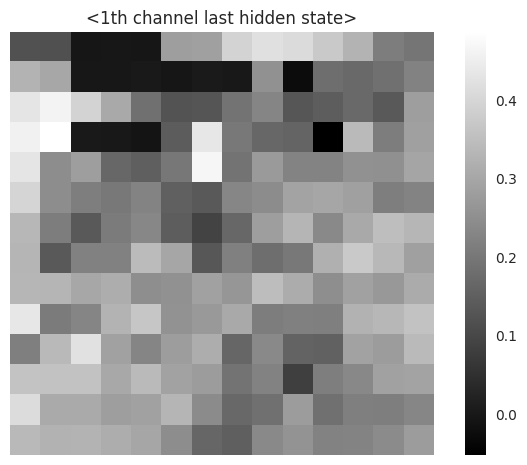

In [465]:
hs_1[:,0].view(14,14).size()

plt.style.use(['seaborn'])
cmap = cm.get_cmap('gray')

hs_l_1 = hs_last_wo_cls[:,0].view(14,14)
plt.imshow(hs_l_1, cmap=cmap)
plt.title(f"<1th channel last hidden state>")
plt.axis('off')
plt.colorbar()
plt.show()

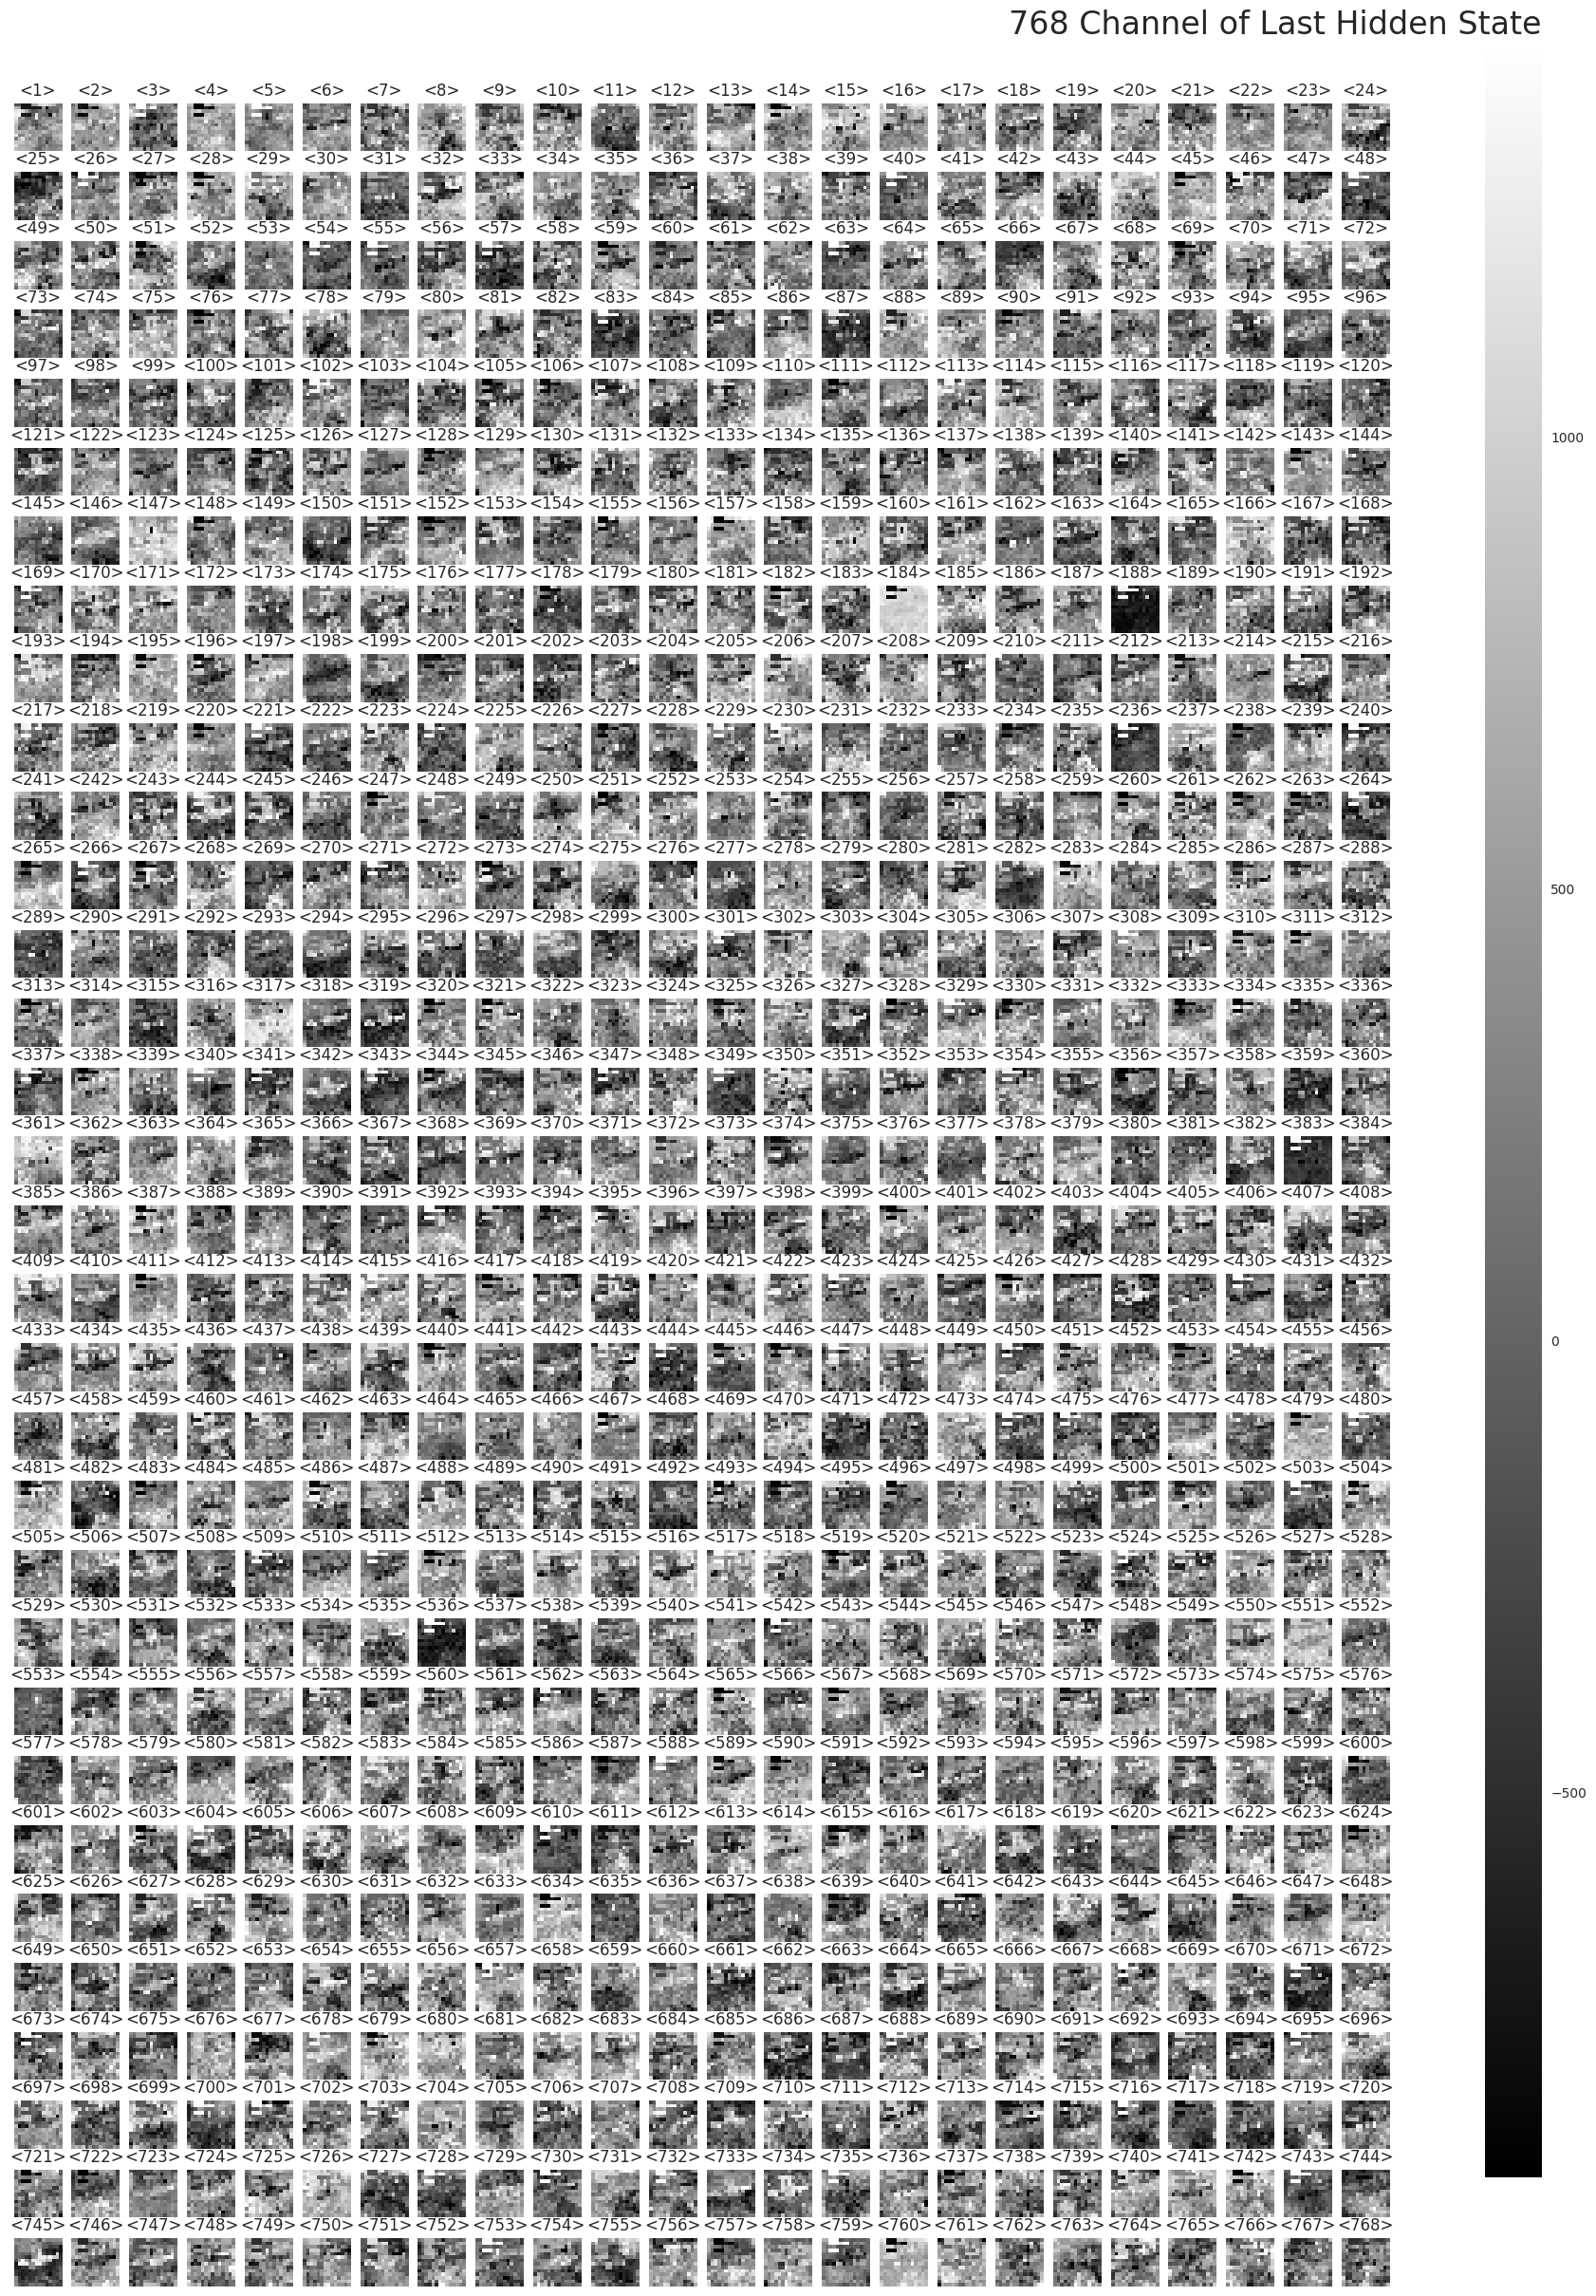

In [491]:
fig, axes = plt.subplots(nrows=32, ncols=24, figsize=(20, 30))
plt.style.use(['seaborn'])
cmap = cm.get_cmap('gray')

for row in range(32):
    for col in range(24):
        idx = row * 24 + col
        
        if idx < 768:
            ax = axes[row][col]
            ax.imshow(hs_last_wo_cls[:,idx].view(14,14), cmap=cmap)
            ax.set_title(f"<{idx+1}>")
            ax.set_axis_off()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.75])
fig.colorbar(im, cax=cbar_ax)      

plt.title("768 Channel of Last Hidden State", fontdict={'fontsize': 24}, loc='right')
plt.show()

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


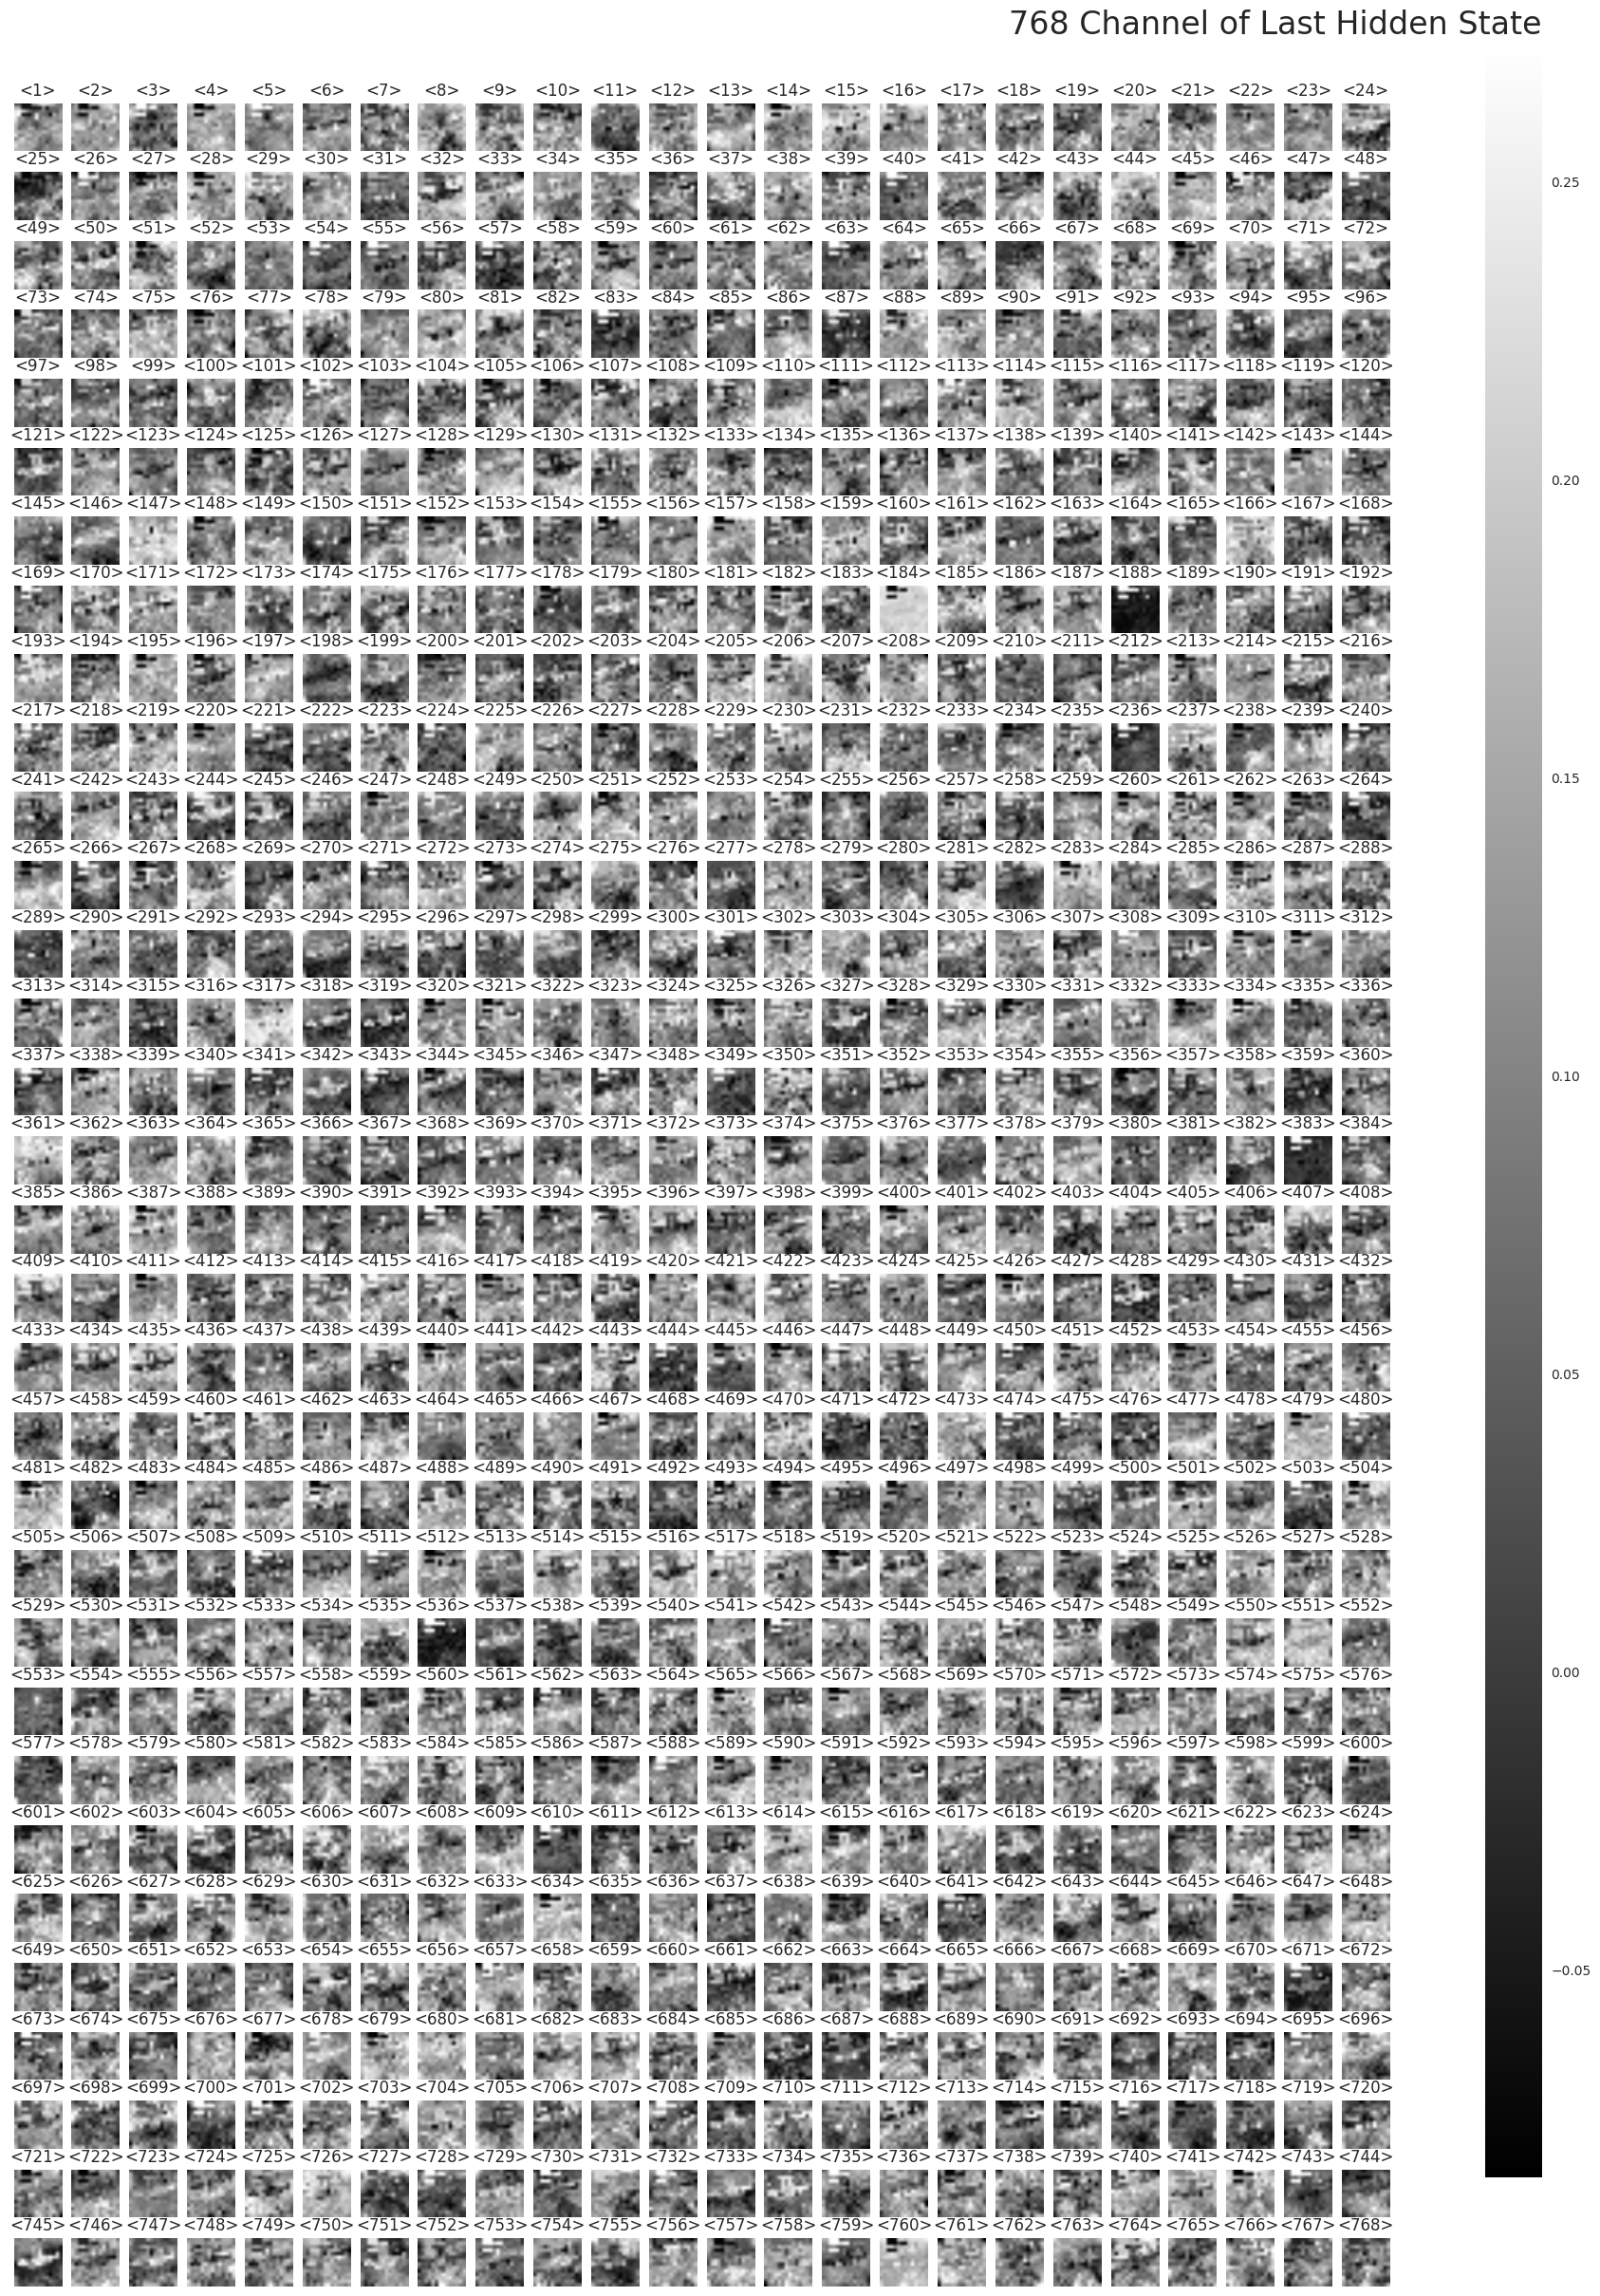

In [497]:
fig, axes = plt.subplots(nrows=32, ncols=24, figsize=(20, 30))
plt.style.use(['seaborn'])
cmap = cm.get_cmap('gray') # import matplotlib.cm as cm

for idx, ax in enumerate(axes.flat):
    hs_l_i = hs_last_wo_cls[:,idx].view(14,14)
    #interpolation - "trilinear"
    hs_l_224 = torch.nn.functional.interpolate(hs_l_i.unsqueeze(0).unsqueeze(0).unsqueeze(0), size=(1,224,224), mode='trilinear')
    hs_l_tri = hs_l_224.squeeze()
    im = ax.imshow(hs_l_tri, cmap=cmap)
    ax.set_title(f"<{idx+1}>")
    ax.set_axis_off()

fig.subplots_adjust(right=0.85) # fig - palette adjust
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.75]) #cbar [x, y, width, height]
fig.colorbar(im, cax=cbar_ax)          
# fig.colorbar(im, ax=axes.ravel().tolist())

plt.title("768 Channel of Last Hidden State", fontdict={'fontsize': 24}, loc='right')
plt.show()

# Appendix
   - Upscaling
       - brute_force
       - interpolation

## 1.  Brute-force

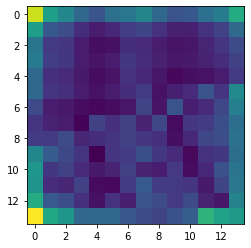

In [227]:
cls_1 = outputs.attentions[0][0][0][0,1:].view(14,14)

plt.imshow(cls_1)

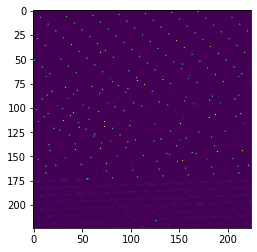

In [226]:
# brute_force resize

# cls_1.resize(224,224) # just resize X
cls_1.resize_(224,224).size() # _ : inplace = True
plt.imshow(cls_1)

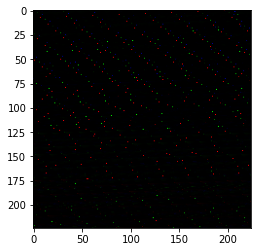

In [240]:
tf_toPILImage = T.ToPILImage()
img = tf_toPILImage(cls_1.resize_(3,224,224))
plt.imshow(img)
# type(img_pip_from_tensor)

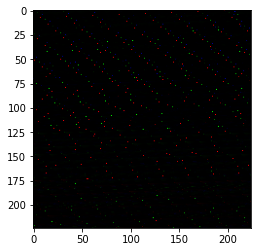

In [241]:
img = T.functional.resize(img, size=(224,224), interpolation= T.functional.InterpolationMode.LANCZOS) #size=(h,w)
plt.imshow(img)
# img.size

## 2. Interpolation
   - trilinear
   - bicubic
   - bilinear
   - linear
   - nearest

In [360]:
cls_1_224 = torch.nn.functional.interpolate(cls_1.unsqueeze(0).unsqueeze(0).unsqueeze(0), size=(1,224,224), mode='trilinear')
cls_1_tri = cls_1_224.squeeze()
cls_1_tri.size()

torch.Size([224, 224])

In [344]:
cls_1_224 = torch.nn.functional.interpolate(cls_1.unsqueeze(0).unsqueeze(0), size=(224,224), mode='bicubic')
cls_1_bi = cls_1_224.squeeze()
cls_1_224.squeeze().size()

torch.Size([224, 224])

In [359]:
cls_1_224 = torch.nn.functional.interpolate(cls_1.unsqueeze(0).unsqueeze(0), size=(224,224), mode='bilinear')
cls_1_bil = cls_1_224.squeeze()
cls_1_bil.size()

torch.Size([224, 224])

In [365]:
cls_1_224 = torch.nn.functional.interpolate(cls_1.unsqueeze(0), size=(224), mode='linear')
cls_1_224 = torch.nn.functional.interpolate(cls_1_224.squeeze().T.unsqueeze(0), size=(224), mode='linear')
cls_1_lin = cls_1_224.squeeze().T
cls_1_lin.size()

torch.Size([224, 224])

In [371]:
cls_1_224 = torch.nn.functional.interpolate(cls_1.unsqueeze(0).unsqueeze(0), size=(224,224), mode='nearest')
cls_1_nr = cls_1_224.squeeze()
cls_1_nr.size()

torch.Size([224, 224])

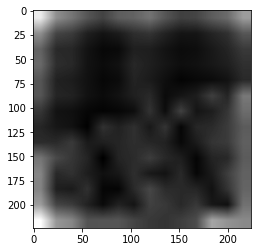

In [339]:
plt.imshow(cls_1_tri)

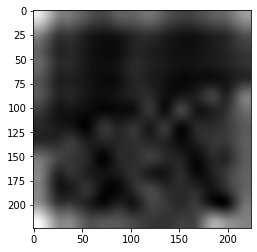

In [345]:
plt.imshow(cls_1_bi)

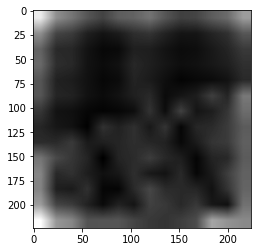

In [348]:
plt.imshow(cls_1_bil)

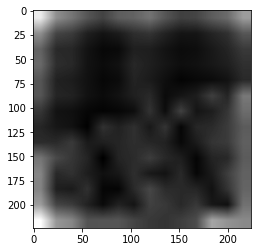

In [366]:
plt.imshow(cls_1_lin)

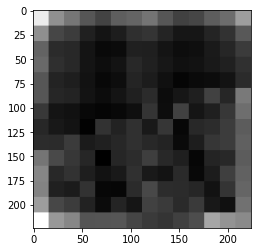

In [372]:
plt.imshow(cls_1_nr)

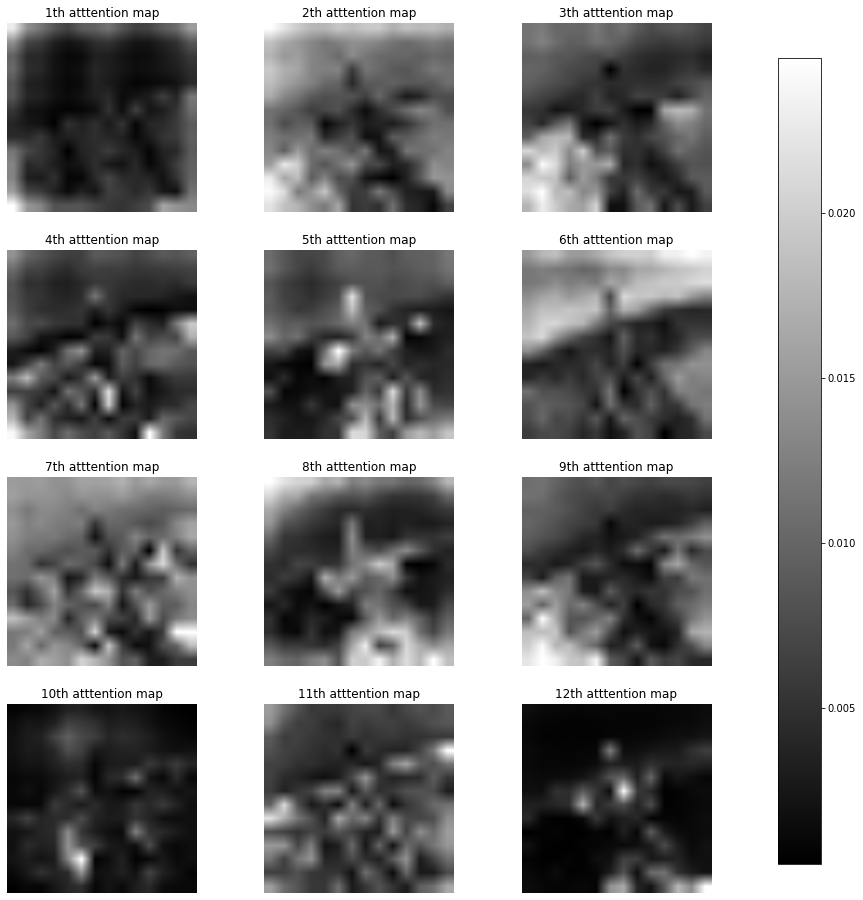

In [376]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 16))
cmap = cm.get_cmap('gray') # import matplotlib.cm as cm

for idx, ax in enumerate(axes.flat):
    cls_i = outputs.attentions[0][0][idx][0,1:].view(14,14)
    #interpolation - "bilinear"
    cls_i_224 = torch.nn.functional.interpolate(cls_i.unsqueeze(0).unsqueeze(0), size=(224,224), mode='bilinear')
    cls_i_bil = cls_i_224.squeeze()
    im = ax.imshow(cls_i_bil, cmap=cmap)
    ax.set_title(f"{idx+1}th atttention map")
    ax.set_axis_off()

fig.subplots_adjust(right=0.8) # fig - palette adjust
cbar_ax = fig.add_axes([0.85, 0.15, 0.04, 0.7]) #cbar [x, y, width, height]
fig.colorbar(im, cax=cbar_ax)          
# fig.colorbar(im, ax=axes.ravel().tolist())

plt.show()